# the program that executes regression

In [1]:
import sys
sys.path.append('..')
from Constants import Constants

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import re

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn
import pyperclip
import os

import scipy.stats

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
mkdir_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}"

os.system("mkdir " + mkdir_path)
os.system("mkdir " + mkdir_path + "/image")
os.system("mkdir " + mkdir_path + "/regression")
os.system("mkdir " + mkdir_path + "/regression/by_phase")

mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240917_kyoto: File exists
mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240917_kyoto/image: File exists
mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240917_kyoto/regression: File exists
mkdir: /Users/miyakooti/repositories/arai_MATLAB_program/csv/analysis_results/20240917_kyoto/regression/by_phase: File exists


256

### ここだけ手動で設定。変更がないか毎度確認すること

In [5]:
pvalue_index = -1

### 分析対象のファイルのパスを正規表現で取得

In [6]:
pathes = glob.glob(f"{Constants.path_to_matlab_repository_folder}/csv/*_*/HRV_and_PLI.csv")
pathes.sort()
pathes

['/Users/miyakooti/repositories/arai_MATLAB_program/csv/0_kumakura/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/10_tenshin/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/11_masanori/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/12_enoki/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/13_ito/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/14_yoshioka/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/15_chizuru/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/1_kim/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/2_souma/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/3_fujii/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/4_tubota/HRV_and_PLI.csv',
 '/Users/miyakooti/repositories/arai_MATLAB_program/csv/5_toki/HRV_and_PLI.csv',
 

In [7]:
len(pathes)

16

# StatsModelsを利用した分析

- [公式ドキュメント](https://www.statsmodels.org/stable/index.html#citation)
- [github](https://github.com/statsmodels/statsmodels)

Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

In [8]:
import statsmodels.api as sm

### フェーズごとの分析

In [9]:
for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0:
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
    
    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
                    
 
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/by_phase/{i}_{target_phase}_regression.csv"
    df.to_csv(save_path)  

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e


saving boredom phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.288818         0.079892             0.014170   
1                      ibi  0.528202         0.029018            -0.040338   
2                       lf  0.407939         0.049420            -0.018478   
3                       hf  0.667431         0.013573            -0.056886   
4                   min_lf  0.568528         0.023780            -0.045950   
5                   min_hf  0.439605         0.043246            -0.025093   
6                    lf/hf  0.571657         0.023402            -0.046355   
7                kubios_lf  0.882108         0.001627            -0.069686   
8                kubios_hf  0.647802         0.015328            -0.055006   
9             kubios_lf/hf  0.824085         0.003651            -0.067517   
10                    sdsd  0.444276         0.042389            -0.026012   
11                 

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e


saving flow phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.230661         0.100864             0.036640   
1                      ibi  0.646155         0.015481            -0.054842   
2                       lf  0.252085         0.092506             0.027685   
3                       hf  0.283082         0.081736             0.016145   
4                   min_lf  0.178614         0.125289             0.062810   
5                   min_hf  0.358794         0.060421            -0.006691   
6                    lf/hf  0.937476         0.000455            -0.070941   
7                kubios_lf  0.133031         0.153774             0.093329   
8                kubios_hf  0.293871         0.078303             0.012467   
9             kubios_lf/hf  0.483046         0.035759            -0.033115   
10                    sdsd  0.095139         0.186199             0.128071   
11                   r

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e


saving ultra phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.982183         0.000037            -0.071389   
1                      ibi  0.806264         0.004442            -0.066669   
2                       lf  0.098162         0.183182             0.124838   
3                       hf  0.104681         0.176975             0.118187   
4                   min_lf  0.047725         0.251652             0.198198   
5                   min_hf  0.098156         0.183189             0.124845   
6                    lf/hf  0.926077         0.000637            -0.070746   
7                kubios_lf  0.077020         0.206486             0.149807   
8                kubios_hf  0.101046         0.180388             0.121845   
9             kubios_lf/hf  0.923692         0.000679            -0.070701   
10                    sdsd  0.636005         0.016444            -0.053810   
11                   

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/3372751496.py:44: FutureWarning: Support for multi-dimensional indexing (e

# 被験者ごとの分析

In [10]:
# def findSubjectName(path):
#     for subject_name in Constants.subject_name_list:
#         if subject_name in path:
#             return subject_name

In [11]:
# for i,path in enumerate(pathes):

#     df = pd.read_csv(path,index_col=0).fillna(0)
    
#     # ここだけ設定してください。ごめんね
#     flow_dataset = df.iloc[2:6]
#     df = df[["bpm", "ibi", "lf", "hf","lf/hf","FC3","FC4","FCz","mean_3ch","concentration_FC3","concentration_FC4","concentration_FCz","questionnaire_average"]]
    
#     export_data = {
#         "target": Constants.target_columns,
#         "linear-p": [],
#         "linear-rsquared": [],
#         "linear-rsquared_adj": [],
#         "linear-coef": [],
#         "nonlinear-p": [],
#         "nonlinear-rsquared": [],
#         "nonlinear-rsquared_adj": [],
#         "nonlinear-coef": [],
#     }
    
#     for target_column in Constants.target_columns:

#             x = flow_dataset[target_column]
#             y = flow_dataset[["questionnaire_average"]]

#             for k in ["linear", "nonlinear"]:
#                 if k=="linear":
#                     # 線形単回帰
#                     X = sm.add_constant(x)
#                     model = sm.OLS(y, X)
#                     results = model.fit()

#                     export_data["linear-p"].append(results.pvalues[target_column])
#                     export_data["linear-rsquared"].append(results.rsquared)
#                     export_data["linear-rsquared_adj"].append(results.rsquared_adj)
#                     export_data["linear-coef"].append(results.params[target_column])
#                 if k=="nonlinear":
#                     # ２次単回帰
#                     x = x[:,np.newaxis]
#                     polynomial_features= PolynomialFeatures(degree=2)
#                     xp = polynomial_features.fit_transform(x)
#                     xp.shape

#                     model = sm.OLS(y, xp)

#                     results = model.fit()

#                     export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
#                     export_data["nonlinear-rsquared"].append(results.rsquared)
#                     export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
#                     export_data["nonlinear-coef"].append(results.params[pvalue_index])
                    
#     print(f"\nsaving {findSubjectName(path)} regression results...\n")    
#     df = pd.DataFrame(export_data)   
#     print(df)

#     save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/subject/{i}_{findSubjectName(path)}_regression.csv"
#     df.to_csv(save_path)  

https://atmarkit.itmedia.co.jp/ait/articles/2109/14/news024.html

# すべてのフェーズ，すべての被験者のデータをまとめて分析

In [12]:
# 使用するデータセットは一つなので，ここでまとめて作っちゃいましょう

for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        
flow_dataset

flow_dataset初期化


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,min_lf,min_hf,...,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,max_concentration_FC3,max_concentration_FC4,max_concentration_FCz,concentration_mean,max_concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
boredom,75.438926,795.345361,41.451926,17.859601,33.455281,0.609819,0.129199,24.0,23.656319,53.599844,3983.461053,0.441351,0.356460,231.553019,291.101937,336.954289,0.863921,859.609245,26.937009,33.864449,39.198542,46.349662,53.650338,93.234866,334.576916,...,318.0,315.0,1.000,0.276021,0.446082,0.437729,0.560950,0.180391,0.162976,0.240775,0.327370,0.481587,0.272161,0.092863,0.222104,0.476316,0.418886,0.471890,0.195709,0.455698,2,2.0,5.0,2.0,2.75
boredom,88.817951,675.539112,40.040559,18.638951,30.130648,0.474576,0.101695,30.0,21.305037,52.333279,3502.757897,0.407103,0.125184,230.918805,688.767033,224.990607,3.061315,1144.676445,20.173282,60.171329,19.655389,75.377431,24.622569,478.893112,193.058120,...,604.0,229.0,2.639,0.448846,0.607136,0.642968,0.732918,0.286166,0.396024,0.466052,0.284452,0.661008,-0.013875,0.047647,-0.007030,0.166432,0.203619,0.118208,0.008914,0.162753,3,2.0,4.0,2.0,2.75
boredom,71.786562,835.811024,47.251002,15.327906,24.798981,0.400000,0.042105,28.0,17.533910,64.333409,3543.767459,0.272548,0.125612,701.772575,1266.585276,184.562388,6.862640,2152.920239,32.596311,58.831036,8.572653,87.281626,12.718374,633.640214,166.823132,...,963.0,202.0,4.770,0.348395,0.550590,0.565329,0.610800,0.308010,0.451657,0.362960,0.278507,0.575573,-0.025012,-0.260113,-0.123365,0.477440,0.243520,0.422430,-0.136163,0.381130,1,1.0,2.0,1.0,1.25
boredom,75.843941,791.098131,66.946482,14.202609,22.917426,0.353630,0.023419,49.0,16.202564,93.024553,4735.122491,0.174175,0.147671,1490.230066,802.798502,199.634560,4.021340,2492.663127,59.784656,32.206458,8.008886,80.084998,19.915002,621.964545,72.667348,...,890.0,242.0,3.680,0.358975,0.495150,0.549294,0.599081,0.207888,0.253009,0.326009,0.259150,0.547842,0.024070,0.000098,0.097890,0.229920,0.227478,0.243923,0.040686,0.233774,2,1.0,4.0,5.0,3.00
boredom,70.209932,854.579946,75.423715,37.476253,61.627738,0.737705,0.409836,48.0,43.577227,97.343777,13326.547703,0.447663,0.253694,1272.262127,1203.311501,1633.576699,0.736612,4109.150328,30.961684,29.283706,39.754610,42.416599,57.583401,1203.034285,1626.589519,...,1939.0,1974.0,0.982,0.381545,0.618994,0.686718,0.722451,0.375563,0.380402,0.303913,0.195918,0.676054,-0.181278,-0.192921,-0.238430,0.181357,0.097037,-0.063873,-0.204210,0.071507,1,3.0,4.0,4.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
overload,67.871602,884.022161,34.863240,15.708439,28.331372,0.519444,0.041667,20.0,20.033207,44.712569,2814.038110,0.448044,0.125341,511.000549,189.042704,189.878838,0.995596,889.922092,57.420819,21.242613,21.336569,49.889669,50.110331,132.063474,187.407128,...,149.0,191.0,0.777,0.142077,0.179835,0.204738,0.273960,0.126628,0.120716,0.227956,0.279774,0.219511,0.278569,0.065311,0.379934,0.599672,0.268157,0.598881,0.241271,0.488903,1,5.0,3.0,6.0,3.75
overload,69.419187,864.314363,52.139367,26.782749,46.957543,0.706522,0.277174,28.0,33.201355,65.283409,6809.394690,0.508573,0.125419,752.580567,322.969379,173.814090,1.858131,1249.364036,60.237092,25.850702,13.912205,65.012103,34.987897,137.844868,162.629793,...,332.0,335.0,0.991,0.299530,0.209866,0.267556,0.467623,0.137759,0.108795,0.209677,0.261999,0.315015,0.238469,0.171739,0.151192,0.432547,0.423674,0.254268,0.187133,0.370163,1,3.0,2.0,2.0,2.00
overload,82.034953,731.395556,33.234373,14.009844,24.283955,0.405345,0.020045,20.0,17.171349,43.779218,2361.686728,0.392226,0.121536,214.582765,128.063278,106.5

In [13]:
flow_dataset_flow = flow_dataset[flow_dataset.index == 'flow']
flow_dataset_flow

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,min_lf,min_hf,...,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,max_concentration_FC3,max_concentration_FC4,max_concentration_FCz,concentration_mean,max_concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
flow,79.327765,756.355612,44.242820,17.134588,30.343738,0.549242,0.094697,30.0,21.456241,58.744774,3959.795486,0.365245,0.133380,861.910228,226.714652,69.884525,3.244132,1158.509405,74.398207,19.569513,6.032279,76.438058,23.561942,226.663881,50.633561,...,290.0,80.0,3.610,0.262003,0.427572,0.435408,0.375186,0.661463,0.526907,0.254461,0.429748,0.412722,0.290671,0.095183,0.407868,0.643084,0.466640,0.723973,0.264574,0.611232,7,7.0,7.0,7.0,7.00
flow,87.338111,686.985321,46.617493,18.416055,30.609661,0.487603,0.092746,32.0,21.644134,62.216533,4230.540844,0.347884,0.120191,617.402231,429.101334,115.147038,3.726551,1161.650604,53.148703,36.938933,9.912364,78.842925,21.157075,180.671900,78.141704,...,224.0,80.0,2.802,0.418069,0.440680,0.478943,0.539982,0.394222,0.337321,0.401383,0.348721,0.486535,0.152582,0.211672,0.185907,0.377347,0.391500,0.346151,0.183387,0.371666,5,7.0,6.0,7.0,6.25
flow,72.682443,825.508855,41.342005,14.527608,24.851616,0.424350,0.035461,26.0,17.572711,55.781898,3079.512264,0.315025,0.128719,531.965118,448.888682,159.181060,2.819988,1140.034861,46.662180,39.374996,13.962824,73.821907,26.178093,144.226177,127.447866,...,446.0,191.0,2.340,0.495359,0.662175,0.658615,0.715267,0.775733,0.819802,0.521416,0.358020,0.678686,-0.136597,-0.353399,-0.227832,0.417393,0.414543,0.427338,-0.239276,0.419758,3,7.0,6.0,7.0,5.75
flow,74.815165,801.976445,63.352008,13.375094,21.043822,0.290461,0.024652,38.0,14.879795,88.328774,4129.039360,0.168459,0.106803,871.492851,588.514432,147.332410,3.994467,1607.339693,54.219581,36.614191,9.166227,79.977843,20.022157,115.852988,37.665841,...,605.0,148.0,4.092,0.356516,0.343713,0.416962,0.506622,0.160450,0.167623,0.259813,0.301159,0.422433,0.175507,0.132430,0.190349,0.401149,0.391244,0.438588,0.166095,0.410327,6,6.0,6.0,6.0,6.00
flow,67.708538,886.151163,79.148964,39.115068,66.801443,0.801170,0.459064,42.0,47.233563,101.334593,15036.899930,0.466115,0.295247,1449.209860,1079.751620,2301.162430,0.469220,4830.123910,30.003575,22.354533,47.641892,31.936678,68.063322,1079.164705,2297.896469,...,843.0,1959.0,0.430,0.844680,0.802310,0.903606,0.900716,0.857674,0.839780,0.755410,0.219345,0.868877,-0.364594,-0.409810,-0.416695,-0.152510,-0.295502,-0.321387,-0.397033,-0.256466,5,5.0,4.0,5.0,4.75
flow,76.990704,779.314861,32.378027,16.124879,31.046235,0.593434,0.070707,22.0,21.953003,40.243677,2775.501469,0.545502,0.323227,150.227110,88.573499,423.957048,0.208921,662.757658,22.666975,13.364387,63.968638,17.281604,82.718396,87.259950,421.876171,...,162.0,391.0,0.415,0.247726,0.313739,0.400612,0.463530,0.160048,0.170242,0.209732,0.175085,0.392627,-0.141867,0.018487,0.089892,-0.016538,0.292082,0.253428,-0.011163,0.176324,7,7.0,5.0,7.0,6.50
flow,76.751127,781.747475,20.354357,7.845791,13.529901,0.113924,0.000000,14.0,9.567004,27.165591,816.478935,0.352174,0.290726,258.674663,117.745036,61.260505,1.922038,437.680204,59.101294,26.902070,13.996636,65.777314,34.222686,58.685100,60.699497,...,90.0,55.0,1.617,0.411424,0.426012,0.651542,0.766278,0.261086,0.331433,0.319203,0.247703,0.614611,-0.130136,-0.086330,-0.062580,0.141213,0.303244,0.246014,-0.093015,0.230157,7,4.0,7.0,7.0,6.25
flow,69.167280,867.462185,45.550500,16.350786,30.723486,0.578652,0.070225,32.0,21.724640,60.689137,4142.031747,0.357966,0.129166,901.317457,646.188819,94.035648,6.871743,1641.541924,54.906758,39.364747,5.728495,87.296333,12.703667,452.638722,71.048030,...,722.0,111.0,6.498,0.334199,0.579350,0.724764,0.712253,0.089325,0.098092,0.283760,0.268271,0.672122,0.073063,0.013922,0.052521,0.296192,0.221539,

In [14]:
# just for rest

for j,path in enumerate(pathes):
    

    df = pd.read_csv(path,index_col=0).fillna(0)

    # column
    # row
    df = df.loc[["rest"]] # seriesとして取り出したいときはこっち
    if j == 0:
        print("flow_dataset初期化")
        flow_dataset_rest = df
    else:
        flow_dataset_rest = pd.concat([flow_dataset_rest, df], axis=0)

flow_dataset初期化


In [15]:
flow_dataset_rest

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,min_lf,min_hf,...,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,max_concentration_FC3,max_concentration_FC4,max_concentration_FCz,concentration_mean,max_concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,73.633422,814.847368,39.978782,20.415642,36.764673,0.617414,0.195251,30.0,25.996395,50.238239,4102.961213,0.517462,0.322956,363.335295,206.618148,481.080971,0.429487,1051.034414,34.569305,19.658552,45.772143,30.044847,69.955153,64.357417,460.355937,...,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
rest,83.421173,719.241860,39.071456,16.975765,27.482735,0.433566,0.062937,24.0,19.432942,51.631492,3152.122556,0.376378,0.129337,163.546115,555.848890,216.755501,2.564405,936.150507,17.470066,59.376018,23.153916,71.944827,28.055173,338.422924,185.617190,...,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,74.830855,801.808290,45.841974,14.946048,23.308434,0.314286,0.033766,24.0,16.481548,62.703624,3246.687778,0.262848,0.129245,340.243575,915.287809,135.159492,6.771909,1390.690875,24.465795,65.815331,9.718874,87.133149,12.866851,448.749867,135.159492,...,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,67.437130,889.717579,108.469791,18.672020,33.520247,0.604046,0.124277,78.0,23.701366,151.703423,11295.842566,0.156235,0.129563,4215.463266,4148.250048,135.783347,30.550507,8499.496661,49.596622,48.805832,1.597546,96.830479,3.169521,3906.197196,133.201562,...,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,73.965976,811.183784,85.603446,33.864907,50.228846,0.605479,0.249315,52.0,35.509528,114.630884,12787.816947,0.309773,0.233232,8054.799197,2345.239998,1369.658598,1.712281,11769.697793,68.436755,19.926085,11.637160,63.130660,36.869340,694.846775,746.898186,...,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,76.683147,782.440506,40.484638,14.764389,27.190249,0.507614,0.038071,28.0,19.226247,53.811054,3250.243506,0.357292,0.226493,307.149519,331.359161,464.755541,0.712975,1103.264222,27.840069,30.034434,42.125497,41.622038,58.377962,245.010936,464.349724,...,327.0,379.0,0.861,0.343346,0.171872,0.419099,0.553422,0.191685,0.212534,0.198741,0.298671,0.381464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,73.813914,812.854881,30.122486,11.049811,19.188027,0.281167,0.015915,16.0,13.567755,40.348339,1719.822140,0.336266,0.259681,92.597021,119.119778,147.253811,0.808942,358.970610,25.795154,33.183713,41.021133,44.719065,55.280935,86.698403,146.956186,...,212.0,146.0,1.448,0.459175,0.295876,0.565212,0.703698,0.205356,0.246868,0.291289,0.395353,0.521595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,72.858474,823.514360,48.520289,17.759135,30.008223,0.496063,0.083990,30.0,21.218726,65.157183,4343.416406,0.325654,0.126823,541.335600,1104.905776,253.860618,4.352411,1900.101994,28.489818,58.149814,13.360368,81.316831,18.683169,659.917108,169.212385,...,883.0,301.0,2.937,0.395495,0.652412,0.738686,0.764774,0.222967,0.249696,0.302828,0.475265,0.718624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,\t\t\t\t,0.0,0.0,0.0,0.0
rest,52.585110,1141.007407,84.278506,52.129831,98.041187,0.851301,0.702602,60.0,69.324312,96.954940,21115.695321,0.715016,0.227221,1336.959861,762.334087,4161.574710,0.183184,6260.868658,21.354223,12.176171,66.469606,15.482295

In [16]:
import pandas as pd
from scipy import stats

In [17]:
mean_3ch_flow = flow_dataset_flow['mean_3ch']
mean_3ch_rest = flow_dataset_rest['mean_3ch']
t_statistic, p_value = stats.ttest_ind(mean_3ch_flow, mean_3ch_rest)


In [18]:
t_statistic

-0.7405509362432405

In [19]:

for i,target_phase in enumerate(Constants.target_phases):


    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/all_regression.csv"
    df.to_csv(save_path)  

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e


saving boredom phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.618599         0.004022            -0.012042   
1                      ibi  0.956134         0.000049            -0.016079   
2                       lf  0.244082         0.021820             0.006043   
3                       hf  0.119105         0.038725             0.023220   
4                   min_lf  0.198163         0.026564             0.010863   
5                   min_hf  0.107713         0.041197             0.025733   
6                    lf/hf  0.955079         0.000052            -0.016077   
7                kubios_lf  0.093088         0.044818             0.029412   
8                kubios_hf  0.080636         0.048412             0.033064   
9             kubios_lf/hf  0.987059         0.000004            -0.016125   
10                    sdsd  0.266336         0.019888             0.004080   
11                 

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e


saving ultra phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.618599         0.004022            -0.012042   
1                      ibi  0.956134         0.000049            -0.016079   
2                       lf  0.244082         0.021820             0.006043   
3                       hf  0.119105         0.038725             0.023220   
4                   min_lf  0.198163         0.026564             0.010863   
5                   min_hf  0.107713         0.041197             0.025733   
6                    lf/hf  0.955079         0.000052            -0.016077   
7                kubios_lf  0.093088         0.044818             0.029412   
8                kubios_hf  0.080636         0.048412             0.033064   
9             kubios_lf/hf  0.987059         0.000004            -0.016125   
10                    sdsd  0.266336         0.019888             0.004080   
11                   

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/1732419904.py:34: FutureWarning: Support for multi-dimensional indexing (e

# ↓描画処理

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

### dataset作りたい時はこれ使って

In [22]:
Constants.target_phases

['boredom', 'flow', 'ultra', 'overload']

In [23]:
for i,target_phase in enumerate(Constants.target_phases):
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        
flow_dataset

flow_dataset初期化


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,min_lf,min_hf,...,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,max_concentration_FC3,max_concentration_FC4,max_concentration_FCz,concentration_mean,max_concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
boredom,75.438926,795.345361,41.451926,17.859601,33.455281,0.609819,0.129199,24.0,23.656319,53.599844,3983.461053,0.441351,0.356460,231.553019,291.101937,336.954289,0.863921,859.609245,26.937009,33.864449,39.198542,46.349662,53.650338,93.234866,334.576916,...,318.0,315.0,1.000,0.276021,0.446082,0.437729,0.560950,0.180391,0.162976,0.240775,0.327370,0.481587,0.272161,0.092863,0.222104,0.476316,0.418886,0.471890,0.195709,0.455698,2,2.0,5.0,2.0,2.75
boredom,88.817951,675.539112,40.040559,18.638951,30.130648,0.474576,0.101695,30.0,21.305037,52.333279,3502.757897,0.407103,0.125184,230.918805,688.767033,224.990607,3.061315,1144.676445,20.173282,60.171329,19.655389,75.377431,24.622569,478.893112,193.058120,...,604.0,229.0,2.639,0.448846,0.607136,0.642968,0.732918,0.286166,0.396024,0.466052,0.284452,0.661008,-0.013875,0.047647,-0.007030,0.166432,0.203619,0.118208,0.008914,0.162753,3,2.0,4.0,2.0,2.75
boredom,71.786562,835.811024,47.251002,15.327906,24.798981,0.400000,0.042105,28.0,17.533910,64.333409,3543.767459,0.272548,0.125612,701.772575,1266.585276,184.562388,6.862640,2152.920239,32.596311,58.831036,8.572653,87.281626,12.718374,633.640214,166.823132,...,963.0,202.0,4.770,0.348395,0.550590,0.565329,0.610800,0.308010,0.451657,0.362960,0.278507,0.575573,-0.025012,-0.260113,-0.123365,0.477440,0.243520,0.422430,-0.136163,0.381130,1,1.0,2.0,1.0,1.25
boredom,75.843941,791.098131,66.946482,14.202609,22.917426,0.353630,0.023419,49.0,16.202564,93.024553,4735.122491,0.174175,0.147671,1490.230066,802.798502,199.634560,4.021340,2492.663127,59.784656,32.206458,8.008886,80.084998,19.915002,621.964545,72.667348,...,890.0,242.0,3.680,0.358975,0.495150,0.549294,0.599081,0.207888,0.253009,0.326009,0.259150,0.547842,0.024070,0.000098,0.097890,0.229920,0.227478,0.243923,0.040686,0.233774,2,1.0,4.0,5.0,3.00
boredom,70.209932,854.579946,75.423715,37.476253,61.627738,0.737705,0.409836,48.0,43.577227,97.343777,13326.547703,0.447663,0.253694,1272.262127,1203.311501,1633.576699,0.736612,4109.150328,30.961684,29.283706,39.754610,42.416599,57.583401,1203.034285,1626.589519,...,1939.0,1974.0,0.982,0.381545,0.618994,0.686718,0.722451,0.375563,0.380402,0.303913,0.195918,0.676054,-0.181278,-0.192921,-0.238430,0.181357,0.097037,-0.063873,-0.204210,0.071507,1,3.0,4.0,4.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
overload,67.871602,884.022161,34.863240,15.708439,28.331372,0.519444,0.041667,20.0,20.033207,44.712569,2814.038110,0.448044,0.125341,511.000549,189.042704,189.878838,0.995596,889.922092,57.420819,21.242613,21.336569,49.889669,50.110331,132.063474,187.407128,...,149.0,191.0,0.777,0.142077,0.179835,0.204738,0.273960,0.126628,0.120716,0.227956,0.279774,0.219511,0.278569,0.065311,0.379934,0.599672,0.268157,0.598881,0.241271,0.488903,1,5.0,3.0,6.0,3.75
overload,69.419187,864.314363,52.139367,26.782749,46.957543,0.706522,0.277174,28.0,33.201355,65.283409,6809.394690,0.508573,0.125419,752.580567,322.969379,173.814090,1.858131,1249.364036,60.237092,25.850702,13.912205,65.012103,34.987897,137.844868,162.629793,...,332.0,335.0,0.991,0.299530,0.209866,0.267556,0.467623,0.137759,0.108795,0.209677,0.261999,0.315015,0.238469,0.171739,0.151192,0.432547,0.423674,0.254268,0.187133,0.370163,1,3.0,2.0,2.0,2.00
overload,82.034953,731.395556,33.234373,14.009844,24.283955,0.405345,0.020045,20.0,17.171349,43.779218,2361.686728,0.392226,0.121536,214.582765,128.063278,106.5

In [24]:
pd.set_option('display.max_rows', 100)

In [25]:
flow_dataset

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,min_lf,min_hf,...,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,max_concentration_FC3,max_concentration_FC4,max_concentration_FCz,concentration_mean,max_concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
boredom,75.438926,795.345361,41.451926,17.859601,33.455281,0.609819,0.129199,24.0,23.656319,53.599844,3983.461053,0.441351,0.356460,231.553019,291.101937,336.954289,0.863921,859.609245,26.937009,33.864449,39.198542,46.349662,53.650338,93.234866,334.576916,...,318.0,315.0,1.000,0.276021,0.446082,0.437729,0.560950,0.180391,0.162976,0.240775,0.327370,0.481587,0.272161,0.092863,0.222104,0.476316,0.418886,0.471890,0.195709,0.455698,2,2.0,5.0,2.0,2.75
boredom,88.817951,675.539112,40.040559,18.638951,30.130648,0.474576,0.101695,30.0,21.305037,52.333279,3502.757897,0.407103,0.125184,230.918805,688.767033,224.990607,3.061315,1144.676445,20.173282,60.171329,19.655389,75.377431,24.622569,478.893112,193.058120,...,604.0,229.0,2.639,0.448846,0.607136,0.642968,0.732918,0.286166,0.396024,0.466052,0.284452,0.661008,-0.013875,0.047647,-0.007030,0.166432,0.203619,0.118208,0.008914,0.162753,3,2.0,4.0,2.0,2.75
boredom,71.786562,835.811024,47.251002,15.327906,24.798981,0.400000,0.042105,28.0,17.533910,64.333409,3543.767459,0.272548,0.125612,701.772575,1266.585276,184.562388,6.862640,2152.920239,32.596311,58.831036,8.572653,87.281626,12.718374,633.640214,166.823132,...,963.0,202.0,4.770,0.348395,0.550590,0.565329,0.610800,0.308010,0.451657,0.362960,0.278507,0.575573,-0.025012,-0.260113,-0.123365,0.477440,0.243520,0.422430,-0.136163,0.381130,1,1.0,2.0,1.0,1.25
boredom,75.843941,791.098131,66.946482,14.202609,22.917426,0.353630,0.023419,49.0,16.202564,93.024553,4735.122491,0.174175,0.147671,1490.230066,802.798502,199.634560,4.021340,2492.663127,59.784656,32.206458,8.008886,80.084998,19.915002,621.964545,72.667348,...,890.0,242.0,3.680,0.358975,0.495150,0.549294,0.599081,0.207888,0.253009,0.326009,0.259150,0.547842,0.024070,0.000098,0.097890,0.229920,0.227478,0.243923,0.040686,0.233774,2,1.0,4.0,5.0,3.00
boredom,70.209932,854.579946,75.423715,37.476253,61.627738,0.737705,0.409836,48.0,43.577227,97.343777,13326.547703,0.447663,0.253694,1272.262127,1203.311501,1633.576699,0.736612,4109.150328,30.961684,29.283706,39.754610,42.416599,57.583401,1203.034285,1626.589519,...,1939.0,1974.0,0.982,0.381545,0.618994,0.686718,0.722451,0.375563,0.380402,0.303913,0.195918,0.676054,-0.181278,-0.192921,-0.238430,0.181357,0.097037,-0.063873,-0.204210,0.071507,1,3.0,4.0,4.0,3.00
boredom,74.841495,801.694301,33.826743,15.629643,28.536238,0.532468,0.057143,24.0,20.178034,43.418627,2752.357208,0.464732,0.226208,131.299495,262.146750,575.422986,0.455572,968.869231,13.551828,27.056980,59.391192,31.298498,68.701502,262.073456,574.915605,...,206.0,494.0,0.418,0.274297,0.312096,0.415012,0.637438,0.128878,0.155111,0.297436,0.190226,0.454849,-0.140224,0.004087,-0.084016,0.247489,0.190367,0.257137,-0.073384,0.231665,1,3.0,2.0,2.0,2.00
boredom,76.028596,789.176744,33.230715,10.524766,17.299501,0.202797,0.002331,16.0,12.232494,45.420276,1745.479158,0.269318,0.147345,980.050626,851.551300,153.977297,5.530369,1985.579223,49.358425,42.886795,7.754780,84.686930,15.313070,587.444519,98.512711,...,385.0,223.0,1.721,0.313061,0.346950,0.437815,0.602253,0.197531,0.168402,0.216386,0.237270,0.462339,-0.051074,0.127397,0.101445,0.135659,0.322124,0.321942,0.059256,0.259908,7,3.0,7.0,6.0,5.75
boredom,70.629782,849.500000,47.316105,16.830978,28.476891,0.504000,0.074667,31.0,20.135488,63.821153,4037.166609,0.315499,0.125231,426.247032,544.320920,113.091923,4.813084,1083.659875,39.334024,50.229868,10.436109,82.797427,17.202573,544.156013,113.091923,...,481.0,133.0,3.627,0.433278,0.594007,0.755913,0.809629,0.135446,0.195780,0.268044,0.253692,0.719850,0.05840

In [26]:
import statsmodels.formula.api as smf

# 1次

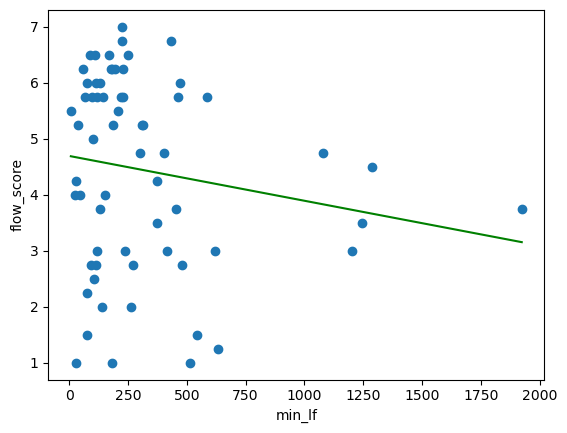

In [27]:
column = "min_lf"
x = flow_dataset[f"{column}"]
xlabel = f"{column}"

y = flow_dataset[["questionnaire_average"]]
ylabel = "flow_score"

result2 = smf.ols(f'questionnaire_average ~ {column}', data=flow_dataset).fit()

#graph
plt.scatter(x, y)
x = x.sort_values()
b0_2, b1_2 = result2.params
plt.plot(x, b0_2 + b1_2*x, 'g')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/image/{ylabel}_1next.png")
plt.show()

# 2次

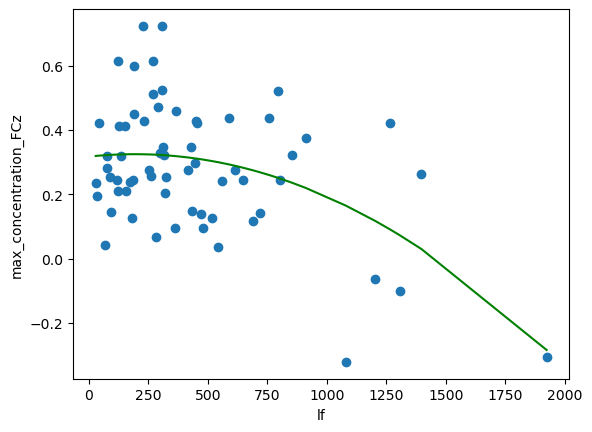

In [29]:
column = "lf"

x = flow_dataset[f"{column}"]
xlabel = f"{column}"

target = "max_concentration_FCz"
y = flow_dataset[[f"{target}"]]
ylabel = f"{target}"

result2 = smf.ols(f'{target} ~ {column} + np.power({column}, 2)', data=flow_dataset).fit()

#graph
plt.scatter(x, y)
x = x.sort_values()
b0_2, b1_2, b2_2 = result2.params
plt.plot(x, b0_2 + b1_2*x + b2_2*x**2, 'g')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/image//{xlabel}_{ylabel}_2next.png")
plt.show()

単純に散布図を描画したい

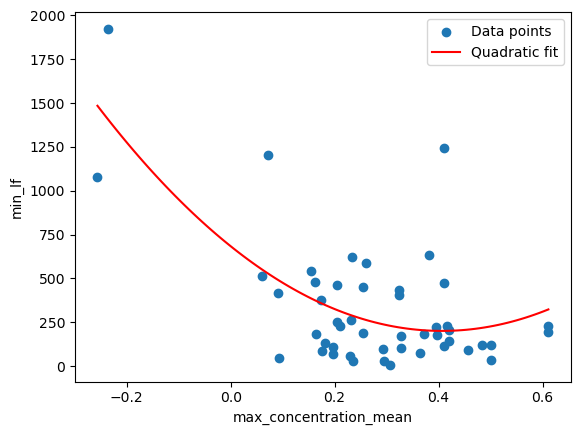

In [50]:
# データの取り出し
column = "max_concentration_mean"
x = flow_dataset[f"{column}"]
xlabel = f"{column}"

target = "min_lf"
y = flow_dataset[f"{target}"]
ylabel = f"{target}"

# 二次回帰のためのフィッティング
coefficients = np.polyfit(x, y, 2)  # 2次の多項式にフィッティング
polynomial = np.poly1d(coefficients)

# 回帰曲線の描画
x_fit = np.linspace(x.min(), x.max(), 100)  # 描画用のx軸の値を生成
y_fit = polynomial(x_fit)  # 回帰曲線のy値を計算

# 散布図と回帰曲線を描画
plt.scatter(x, y, label='Data points')
plt.plot(x_fit, y_fit, color='red', label='Quadratic fit')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.show()

# overloadを抜いたやつで分析してみる

In [36]:
# 使用するデータセットは一つなので，ここでまとめて作っちゃいましょう

for i,target_phase in enumerate(Constants.target_phases):
    
    if target_phase == "overload":
        continue
    
    for j,path in enumerate(pathes):

        df = pd.read_csv(path,index_col=0).fillna(0)
        # column
        # row
        df = df.loc[[target_phase]] # seriesとして取り出したいときはこっち
        if j == 0 and i == 0:
            print("flow_dataset初期化")
            flow_dataset = df
        else:
            flow_dataset = pd.concat([flow_dataset, df], axis=0)
        

for i,target_phase in enumerate(Constants.target_phases):


    export_data = {    
        "target": Constants.target_columns,
        "linear-p": [],
        "linear-rsquared": [],
        "linear-rsquared_adj": [],
        "linear-coef": [],
        "nonlinear-p": [],
        "nonlinear-rsquared": [],
        "nonlinear-rsquared_adj": [],
        "nonlinear-coef": [],
    }

    for target_column in Constants.target_columns:
        
        x = flow_dataset[target_column]
        y = flow_dataset[["questionnaire_average"]]
        
        for k in ["linear", "nonlinear"]:
            if k=="linear":
                # 線形単回帰
                X = sm.add_constant(x)
                model = sm.OLS(y, X)
                results = model.fit()

                export_data["linear-p"].append(results.pvalues[target_column])
                export_data["linear-rsquared"].append(results.rsquared)
                export_data["linear-rsquared_adj"].append(results.rsquared_adj)
                export_data["linear-coef"].append(results.params[target_column])
            if k=="nonlinear":
                # ２次単回帰
                x = x[:,np.newaxis]
                polynomial_features= PolynomialFeatures(degree=2)
                xp = polynomial_features.fit_transform(x)
                xp.shape

                model = sm.OLS(y, xp)
                
                results = model.fit()
                
                export_data["nonlinear-p"].append(results.pvalues[pvalue_index])
                export_data["nonlinear-rsquared"].append(results.rsquared)
                export_data["nonlinear-rsquared_adj"].append(results.rsquared_adj)
                export_data["nonlinear-coef"].append(results.params[pvalue_index])
    
    print(f"\nsaving {target_phase} phase regression results...\n")
    df = pd.DataFrame(export_data)   
    print(df)
    save_path = f"{Constants.path_to_matlab_repository_folder}/csv/analysis_results/{Constants.folder_name}/regression/all_regressiton_without_overload.csv"
    df.to_csv(save_path)  

flow_dataset初期化


/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e


saving boredom phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.522944         0.008928            -0.012617   
1                      ibi  0.923715         0.000201            -0.021533   
2                       lf  0.043367         0.085777             0.065902   
3                       hf  0.028940         0.099536             0.079960   
4                   min_lf  0.040635         0.087986             0.068160   
5                   min_hf  0.035873         0.092224             0.072489   
6                    lf/hf  0.914261         0.000255            -0.021479   
7                kubios_lf  0.016037         0.119641             0.100502   
8                kubios_hf  0.020050         0.112039             0.092735   
9             kubios_lf/hf  0.909853         0.000282            -0.021451   
10                    sdsd  0.090147         0.061158             0.040748   
11                 

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e


saving flow phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.522944         0.008928            -0.012617   
1                      ibi  0.923715         0.000201            -0.021533   
2                       lf  0.043367         0.085777             0.065902   
3                       hf  0.028940         0.099536             0.079960   
4                   min_lf  0.040635         0.087986             0.068160   
5                   min_hf  0.035873         0.092224             0.072489   
6                    lf/hf  0.914261         0.000255            -0.021479   
7                kubios_lf  0.016037         0.119641             0.100502   
8                kubios_hf  0.020050         0.112039             0.092735   
9             kubios_lf/hf  0.909853         0.000282            -0.021451   
10                    sdsd  0.090147         0.061158             0.040748   
11                   r

/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:,np.newaxis]
/var/folders/4_/zl9w1kqn3wj4cv0147kh6bc40000gn/T/ipykernel_49759/2736406265.py:54: FutureWarning: Support for multi-dimensional indexing (e


saving overload phase regression results...

                    target  linear-p  linear-rsquared  linear-rsquared_adj  \
0                      bpm  0.522944         0.008928            -0.012617   
1                      ibi  0.923715         0.000201            -0.021533   
2                       lf  0.043367         0.085777             0.065902   
3                       hf  0.028940         0.099536             0.079960   
4                   min_lf  0.040635         0.087986             0.068160   
5                   min_hf  0.035873         0.092224             0.072489   
6                    lf/hf  0.914261         0.000255            -0.021479   
7                kubios_lf  0.016037         0.119641             0.100502   
8                kubios_hf  0.020050         0.112039             0.092735   
9             kubios_lf/hf  0.909853         0.000282            -0.021451   
10                    sdsd  0.090147         0.061158             0.040748   
11                

# 線形重回帰分析（マルチこに気をつけよう）

In [65]:
# x = flow_dataset[["bpm", "ibi","mean_3ch"]]
# y = flow_dataset[["questionnaire_average"]]

# #全要素が1の列を説明変数の先頭に追加,切片をつけるために必ず必要
# X = sm.add_constant(x)
 
# #モデルの設定
# model = sm.OLS(y, X)
 
# #回帰分析の実行
# results = model.fit()
 
# #結果の詳細を表示
# print(results.summary())

## いい結果のように思えるが、多重共線性により偽の有意性が出てしまっている

### 参考
- https://takacity.blog.fc2.com/blog-entry-305.html
- https://self-development.info/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E8%84%B1%E5%87%BA%E3%80%91statsmodels%E3%81%AB%E3%82%88%E3%82%8B%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E7%B5%90%E6%9E%9C%E3%81%AE%E8%A6%8B%E6%96%B9/
- https://teratail.com/questions/256310

In [66]:
# 決定係数
# 0.9以上	非常によい
# 0.7以上0.9未満	よい
# 0.5以上0.7未満	あまりよくない
# 0.5未満	悪い

# Dep. Variable:     questionnaire_average   R-squared:                       0.915（決定係数。説明変数が目的変数をどれくらい説明できるか）
# Model:                               OLS   Adj. R-squared:                  0.893（自由度調整済み決定係数）
# Method:                    Least Squares   F-statistic:                     42.82（F値）
# Date:                   Fri, 13 Jan 2023   Prob (F-statistic):            0.00282（F値の現れる確率）
# Time:                           12:17:03   Log-Likelihood:                 2.8630
# No. Observations:           データの行数   AIC:                            -1.726
# Df Residuals:               残差の自由度   BIC:                            -2.142
# Df Model:                   要因の自由度                                        
# Covariance Type:  nonrobust（変数間の相関関係）


#       coef（回帰係数。傾き）    std err（標準誤差）  t      P>|t|      [0.025  0.975]
# ------------------------------------------------------------------------------
# const          7.3625      0.174     42.246      0.000       6.879       7.846
# lf         -6.729e-06   1.03e-06     -6.544      0.003   -9.58e-06   -3.87e-06
# ==============================================================================
# Omnibus:                          nan   Durbin-Watson:                   1.765
# Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.156
# Skew:                          -0.179   Prob(JB):                        0.925
# Kurtosis:                       2.296   Cond. No.                     3.93e+05
# ==============================================================================

In [67]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_criteria',


In [68]:
print(results.__doc__)


    Results class for for an OLS model.

    Parameters
    ----------
    model : RegressionModel
        The regression model instance.
    params : ndarray
        The estimated parameters.
    normalized_cov_params : ndarray
        The normalized covariance parameters.
    scale : float
        The estimated scale of the residuals.
    cov_type : str
        The covariance estimator used in the results.
    cov_kwds : dict
        Additional keywords used in the covariance specification.
    use_t : bool
        Flag indicating to use the Student's t in inference.
    **kwargs
        Additional keyword arguments used to initialize the results.

    See Also
    --------
    RegressionResults
        Results store for WLS and GLW models.

    Notes
    -----
    Most of the methods and attributes are inherited from RegressionResults.
    The special methods that are only available for OLS are:

    - get_influence
    - outlier_test
    - el_test
    - conf_int_el
    


In [69]:
dir(results.params)

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__redu

- [pandas dictionary出力](https://note.nkmk.me/python-pandas-to-csv/)
- [pandas dictionary出力](https://atmarkit.itmedia.co.jp/ait/articles/2109/14/news024.html)

# sandbox

In [70]:
flow_dataset

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,min_lf,min_hf,...,kubios_lf,kubios_hf,kubios_lf/hf,FpZ,FC3,FC4,FCz,O1,O2,Fp2,mean_all,mean_3ch,concentration_FC3,concentration_FC4,concentration_FCz,max_concentration_FC3,max_concentration_FC4,max_concentration_FCz,concentration_mean,max_concentration_mean,difficulty,fast,fulfillment,absorb,questionnaire_average
rest,73.633422,814.847368,39.978782,20.415642,36.764673,0.617414,0.195251,30.0,25.996395,50.238239,4102.961213,0.517462,0.322956,363.335295,206.618148,481.080971,0.429487,1051.034414,34.569305,19.658552,45.772143,30.044847,69.955153,64.357417,460.355937,...,257.0,510.0,0.500,0.470375,0.718243,0.530592,0.783054,0.352428,0.286579,0.390179,0.504493,0.677296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.00
rest,83.421173,719.241860,39.071456,16.975765,27.482735,0.433566,0.062937,24.0,19.432942,51.631492,3152.122556,0.376378,0.129337,163.546115,555.848890,216.755501,2.564405,936.150507,17.470066,59.376018,23.153916,71.944827,28.055173,338.422924,185.617190,...,591.0,219.0,2.700,0.422667,0.593262,0.690615,0.725889,0.310892,0.438972,0.430201,0.516071,0.669922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,74.830855,801.808290,45.841974,14.946048,23.308434,0.314286,0.033766,24.0,16.481548,62.703624,3246.687778,0.262848,0.129245,340.243575,915.287809,135.159492,6.771909,1390.690875,24.465795,65.815331,9.718874,87.133149,12.866851,448.749867,135.159492,...,1044.0,133.0,7.863,0.367564,0.525578,0.305216,0.487435,0.320239,0.311307,0.395218,0.387508,0.439410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,67.437130,889.717579,108.469791,18.672020,33.520247,0.604046,0.124277,78.0,23.701366,151.703423,11295.842566,0.156235,0.129563,4215.463266,4148.250048,135.783347,30.550507,8499.496661,49.596622,48.805832,1.597546,96.830479,3.169521,3906.197196,133.201562,...,3530.0,90.0,39.337,0.413260,0.519220,0.549392,0.696971,0.218319,0.247750,0.270101,0.416431,0.588528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,73.965976,811.183784,85.603446,33.864907,50.228846,0.605479,0.249315,52.0,35.509528,114.630884,12787.816947,0.309773,0.233232,8054.799197,2345.239998,1369.658598,1.712281,11769.697793,68.436755,19.926085,11.637160,63.130660,36.869340,694.846775,746.898186,...,2373.0,2504.0,0.948,0.254564,0.437716,0.493796,0.484021,0.533929,0.538550,0.234585,0.425309,0.471844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,76.683147,782.440506,40.484638,14.764389,27.190249,0.507614,0.038071,28.0,19.226247,53.811054,3250.243506,0.357292,0.226493,307.149519,331.359161,464.755541,0.712975,1103.264222,27.840069,30.034434,42.125497,41.622038,58.377962,245.010936,464.349724,...,327.0,379.0,0.861,0.343346,0.171872,0.419099,0.553422,0.191685,0.212534,0.198741,0.298671,0.381464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,73.813914,812.854881,30.122486,11.049811,19.188027,0.281167,0.015915,16.0,13.567755,40.348339,1719.822140,0.336266,0.259681,92.597021,119.119778,147.253811,0.808942,358.970610,25.795154,33.183713,41.021133,44.719065,55.280935,86.698403,146.956186,...,212.0,146.0,1.448,0.459175,0.295876,0.565212,0.703698,0.205356,0.246868,0.291289,0.395353,0.521595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,\t\t\t\t,0.0,0.0,0.0,0.00
rest,72.858474,823.514360,48.520289,17.759135,30.008223,0.496063,0.083990,30.0,21.218726,65.157183,4343.416406,0.325654,0.126823,541.335600,1104.905776,253.860618,4.352411,1900.101994,28.489818,58.149814,13.360368,81.316831,18.683169,659.917108,169.212385,...,883.0,301.0,2.937,0.395495,0.652412,0.738686,0.764774,0.222967,0.249696,0.302828,0.475265,0.718

In [71]:
import scipy.stats as stats

